<span style="float: left;padding: 1.3em">![logo](../logo.png)</span>

# Gravitational Wave Open Data Workshop

## Tutorial 2.1 PyCBC Tutorial, An introduction to matched-filtering

We will be using the [PyCBC](https://pycbc.org) library, which is used to study gravitational-wave data, find astrophysical sources due to compact binary mergers, and study their parameters. These are some of the same tools that the LIGO and Virgo collaborations use to find gravitational waves in LIGO/Virgo data 

In this tutorial we will walk through how to find a specific signal in LIGO data. We present matched filtering as a cross-correlation, in both the time domain and the frequency domain. In the next tutorial (2.2), we use the method as encoded in PyCBC, which is optimal in the case of Gaussian noise and a known signal model. In reality our noise is not entirely Gaussian, and in practice we use a variety of techniques to separate signals from noise in addition to the use of the matched filter. 

View this tutorial on [Google Colaboratory](https://colab.research.google.com/github/gw-odw/odw/blob/main/Tutorials/Day_2/Tuto_2.1_Matched_filtering_introduction.ipynb) or launch [mybinder](https://mybinder.org/v2/gh/gw-odw/odw/HEAD).

See [additional examples](https://pycbc.org/pycbc/latest/html/#library-examples-and-interactive-tutorials) and [documentation](https://pycbc.org/pycbc/latest/html/index.html).

In [36]:
# Those 2 lines are just to avoid some harmless warnings when importing packages
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

## Installation (execute only if running on a cloud platform, like Google Colab, or if you haven't done the installation already!)

> ⚠️ **Warning**: restart the runtime after running the cell below.
>
> To do so, click "Runtime" in the menu and choose "Restart and run all".

In [2]:
# -- Use the following for Google Colab
#! pip install -q 'lalsuite==7.25' 'PyCBC==2.4.1'

## Matched-filtering: Finding well modelled signals in Gaussian noise

Matched filtering can be shown to be the optimal method for "detecting" _known_ signals in _Gaussian_ noise. We'll explore those two assumptions a little later, but for now let's demonstrate how this works.

Let's assume you have a stretch of noise, white noise to start:

In [152]:
import numpy
# The first import of matplotlib can take some time (especially on cloud platforms). This is normal.
import matplotlib.pyplot as plt

# specify the sample rate.
# LIGO raw data is sampled at 16384 Hz (=2^14 samples/second).
# It captures signal frequency content up to f_Nyquist = 8192 Hz.
# Here, we will make the computation faster by sampling at a lower rate.
sample_rate = 1024 # samples per second
data_length = 1024 # seconds

# Generate a long stretch of white noise: the data series and the time series.
data = numpy.random.normal(size=[sample_rate * data_length])
times = numpy.arange(len(data)) / float(sample_rate)

we study the magnitude of the noise which is $O(1)$. We compute its in-phase autocorrelation i.e. the maximum value of the cross correlation of the signal with itself which occurs for when the cross correlation is computed with 0 lag. Correlation scales with time $t$ as $O(t)$ so an order $O(1)$ signal of length $t$ with 1024 data points per second will have a autocorrelation of order $1024 t$.

In [153]:
time=16
max(numpy.correlate(data[0:1024*time], data[0:1024*time], mode='full'))

16195.896544538831

And then let's add a gravitational wave signal to some random part of this data.

In [154]:
from pycbc.waveform import get_td_waveform

# the "approximant" (jargon for parameterized waveform family).
# IMRPhenomD(a phenomenological Inspiral–Merger–Ringdown wafeform model) is defined in the frequency domain, but we'll get it in the time domain (td).
# It runs fast, but it doesn't include effects such as non-aligned component spin, or higher order modes.
apx = 'IMRPhenomD'

Reference for [IMRPhenomD](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.93.044006). You can specify [many parameters](https://pycbc.org/pycbc/latest/html/pycbc.waveform.html?highlight=get_td_waveform#pycbc.waveform.waveform.get_td_waveform), but here, we'll use defaults for everything except the masses.

`get_td_waveform` returns both $h_+$ and $h_{\times}$, but we'll only use $h_+$ for now.

In [155]:
hp1, _ = get_td_waveform(approximant=apx,
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/sample_rate,
                         f_lower=25)

Text(0, 0.5, 'Normalized amplitude')

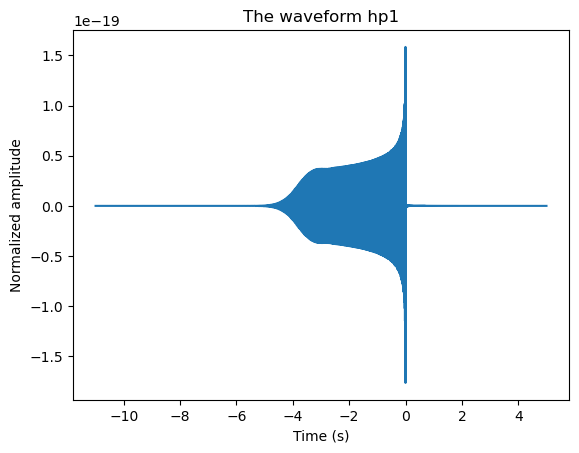

In [156]:
plt.figure()
plt.title("The waveform hp1")
plt.plot(hp1.sample_times, hp1)
plt.xlabel('Time (s)')
plt.ylabel('Normalized amplitude')

The amplitude of gravitational-wave signals is normally of order $10^{-20}$. The GW signal is approximately 16 seconds long and so has around 16000 data points, we expect its autocorrelation to be around $10^{-20} * 10^{-20} * 10000 = 10^{-36}$

In [157]:
len(hp1)

16384

In [158]:
max(numpy.correlate(hp1, hp1, mode='full'))

4.263156798581444e-36

To demonstrate our method on white noise with amplitude $O(1)$ we normalize our signal using the square root of the in-phase autocorrelation of the signal divide by the signal length.

Simiarly, in this case we can interpret the cross-correlation of the signal with white noise as a signal-to-noise ratio time series, the maximum of which gives the signal to noise ratio. This also depends on the signal length.

In [159]:
norm_squared_per_unit_time = max(numpy.correlate(hp1, hp1, mode='full')) / len(hp1)

hp1_normed = hp1 / (norm_squared_per_unit_time)**0.5

The signal is now the same magnitude as the noise. We would like it to be a little harder to find so we divide the signal by a factor of 10.

In [160]:
hp1_example=hp1_normed / 10

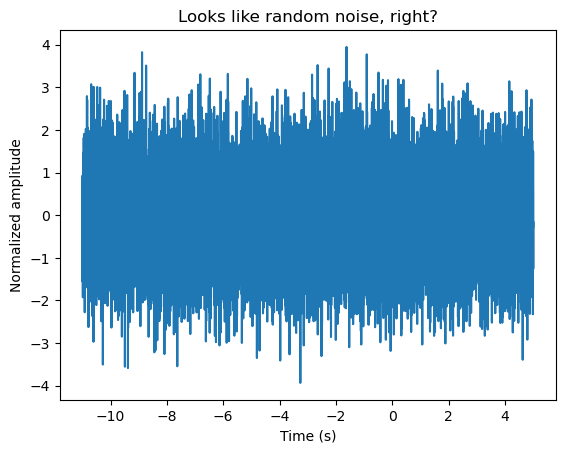

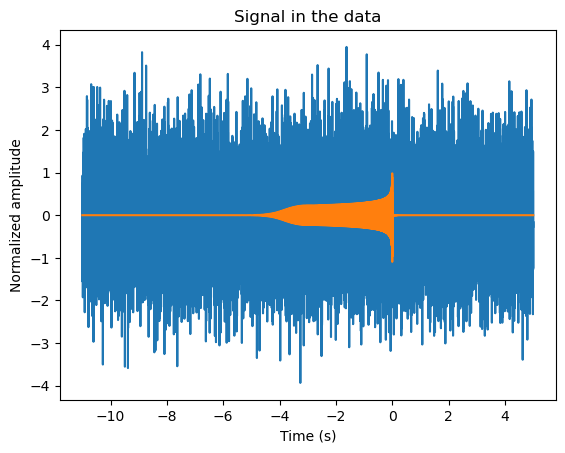

In [161]:
# note that in this figure, the waveform amplitude is of order 1.
# The duration (for frequency above f_lower=25 Hz) is only 3 or 4 seconds long.
# The waveform is "tapered": slowly ramped up from zero to full strength, over the first second or so.
# It is zero-padded at earlier times.


# Shift the waveform to start at a random time in the Gaussian noise data.
waveform_start = numpy.random.randint(0, len(data) - len(hp1_example))
data[waveform_start:waveform_start+len(hp1_example)] += hp1_example.numpy()

plt.figure()
plt.title("Looks like random noise, right?")
plt.plot(hp1_example.sample_times, data[waveform_start:waveform_start+len(hp1_example)])
plt.xlabel('Time (s)')
plt.ylabel('Normalized amplitude')

plt.figure()
plt.title("Signal in the data")
plt.plot(hp1_example.sample_times, data[waveform_start:waveform_start+len(hp1_example)])
plt.plot(hp1_example.sample_times, hp1_example)
plt.xlabel('Time (s)')
plt.ylabel('Normalized amplitude')
plt.show()

To search for this signal we can cross-correlate the signal with the entire dataset -> Not in any way optimized at this point, just showing the method.

We will do the cross-correlation in the time domain, once for each time step. It runs slowly...

max cross-correlation, unwhitened data:  149.82018311828634
mean cross-correlation, unwhitened data:  10.185326319751976
SNR = max/mean:  14.709414152764683


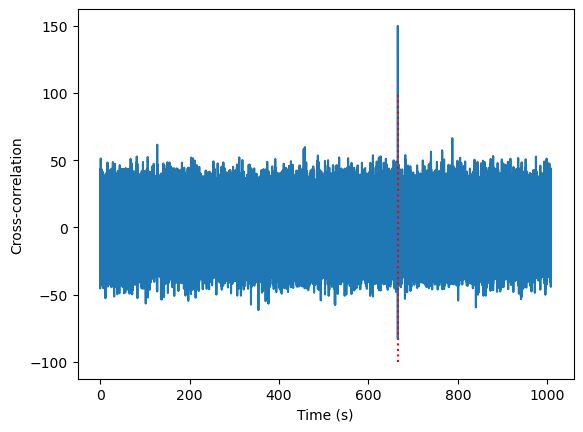

In [162]:
# the allowed "lags" are up to len(data)-len(hp1)
cross_correlation = numpy.zeros([len(data)-len(hp1_example)])
hp1_example_numpy = hp1_example.numpy()
# for each lag compute the cross-correlation of the signal with the data via a dot product.
for i in range(len(data) - len(hp1_example_numpy)):
    cross_correlation[i] = (hp1_example_numpy * data[i:i+len(hp1_example_numpy)]).sum()

cross_correlation_abs = numpy.abs(cross_correlation)
cross_correlation_max = max(cross_correlation_abs)
# compare to the mean of the abs value of the CC of the signal with noise 
# (i.e. away from the signal injection)
# can also include all noise + signal as the signal is localised so has 
# little effect on the mean of the CC SNR time series
cross_correlation_mean  = numpy.mean(cross_correlation_abs[0:400*1024])
print("max cross-correlation, unwhitened data: ", cross_correlation_max)
print("mean cross-correlation, unwhitened data: ", cross_correlation_mean)
print("SNR = max/mean: ", cross_correlation_max/cross_correlation_mean)

# plot the cross-correlated data vs time. Superimpose the location of the start of the signal;
# this is where we should find a peak in the cross-correlation.
plt.figure()
times = numpy.arange(len(data) - len(hp1_example_numpy)) / float(sample_rate)
plt.plot(times, cross_correlation)
plt.plot([waveform_start/float(sample_rate), waveform_start/float(sample_rate)], [-100,100],'r:')
plt.xlabel('Time (s)')
plt.ylabel('Cross-correlation')
plt.show()

## Detection in Colored Noise

Here you can see that the largest spike from the cross-correlation comes at the time of the signal. We only really need one more ingredient to describe matched-filtering: "Colored" noise (Gaussian noise but with a frequency-dependent variance; white noise has frequency-independent variance). 

Let's repeat the process, but generate a stretch of data colored with LIGO's zero-detuned--high-power noise curve. We'll use the PyCBC library to do this.

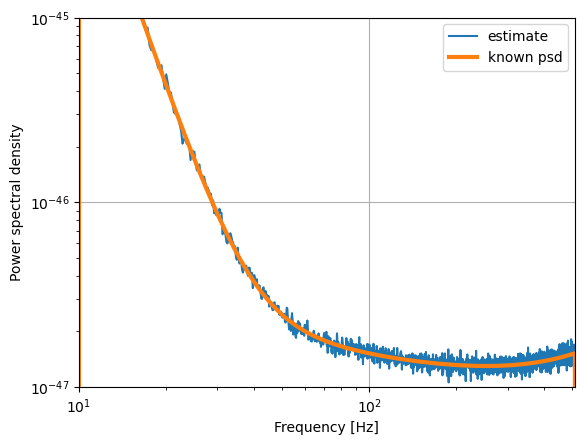

In [163]:
# https://pycbc.org/pycbc/latest/html/noise.html
import pycbc.noise
import pycbc.psd

# The color of the noise matches a PSD which you provide:
# Generate a PSD matching Advanced LIGO's zero-detuned--high-power noise curve 
f_low = 10.0 # lower frequency cutoff for analysis hz
delta_f = 1.0 / 128 # frequency spacing/resolution of bins for the PSD
# number of frequency bins f_len for the PSD, 
# goes from 0 to f_Nyquist which is half the sample rate, plus one
f_len = int(sample_rate / (2 * delta_f)) + 1 
psd = pycbc.psd.aLIGOZeroDetHighPower(f_len, delta_f, f_low)

# Generate colored noise
delta_t = 1.0 / sample_rate
detector_noise = pycbc.noise.noise_from_psd(data_length*sample_rate, delta_t, psd, seed=127)

# check work by reestimate the power spectral density for the coloured noisy data 
# using the "welch" method. We'll choose 4 seconds PSD samples that are overlapped 50%
seg_len = int(4 / delta_t)
seg_stride = int(seg_len / 2)
estimated_psd = pycbc.psd.welch(detector_noise,seg_len=seg_len,seg_stride=seg_stride)

# plot it:
plt.loglog(estimated_psd.sample_frequencies, estimated_psd, label='estimate')
plt.loglog(psd.sample_frequencies, psd, linewidth=3, label='known psd')
plt.xlim(xmin=f_low, xmax=512)
plt.ylim(1e-47, 1e-45)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power spectral density')
plt.legend()
plt.grid()
plt.show()

# add the signal, this time, with a "typical" amplitude. 
# I.e. dont normalize it to 1 instead we divide by 1000 to get an indicative signal amplitude
data2 = detector_noise
hp1n=hp1/1000
hp1np = hp1n.numpy()
data2[waveform_start:waveform_start+len(hp1)] += hp1np

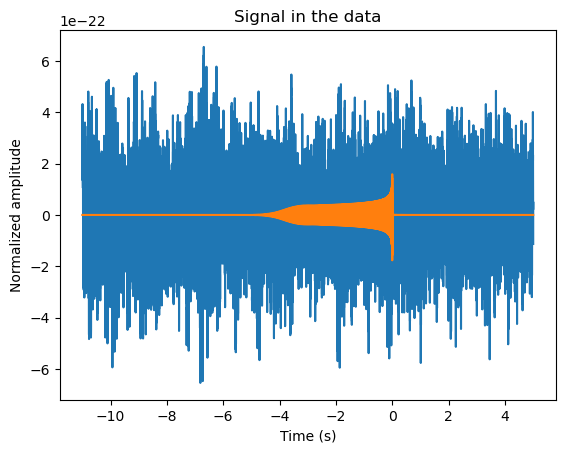

In [164]:
plt.figure()
plt.title("Signal in the data")
plt.plot(hp1.sample_times, data2[waveform_start:waveform_start+len(hp1n)])
plt.plot(hp1.sample_times, hp1np)
plt.xlabel('Time (s)')
plt.ylabel('Normalized amplitude')
plt.show()

Then all we need to do is to "whiten" both the data, and the template waveform. This can be done, in the frequency domain, by dividing both by the PSD of the detector noise. This *can* be done in the time domain as well, but it's more intuitive in the frequency domain

In [165]:
# Generate a PSD for whitening the data
from pycbc.types import TimeSeries

# The detector noise PSD, sampled properly for the noisy data 
# i.e. the frequency resolution is set to one over the length of the data, uncertainty principle
delta_f = 1.0 / data_length
f_len = int(sample_rate / (2 * delta_f)) + 1
psd_td = pycbc.psd.aLIGOZeroDetHighPower(f_len, delta_f, 0)

# The signal PSD, sampled properly for the signal
delta_f = sample_rate / float(len(hp1))
f_len = int(sample_rate / (2 * delta_f)) + 1
psd_hp1 = pycbc.psd.aLIGOZeroDetHighPower(f_len, delta_f, 0)

# The 0th and Nth values are zero. Set them to a nearby value to avoid dividing by zero.
psd_td[0] = psd_td[1]
psd_td[len(psd_td) - 1] = psd_td[len(psd_td) - 2]
# Same, for the PSD sampled for the signal
psd_hp1[0] = psd_hp1[1]
psd_hp1[len(psd_hp1) - 1] = psd_hp1[len(psd_hp1) - 2]

# convert both noisy data and the signal to frequency domain,
# and divide each by ASD=PSD**0.5, then convert back to time domain.
# This "whitens" the data and the signal template. 
data_whitened = (data2.to_frequencyseries() / psd_td**0.5).to_timeseries()
hp1_whitened = (hp1n.to_frequencyseries() / psd_hp1**0.5).to_timeseries()

Now let's do the correlation, in the time domain, first with unwhitened data and template.

max cross-correlation, unwhitened data:  4.402297247242217e-42
std cross-correlation, unwhitened data:  3.809384053498458e-43
SNR = max/std:  11.556454233589916


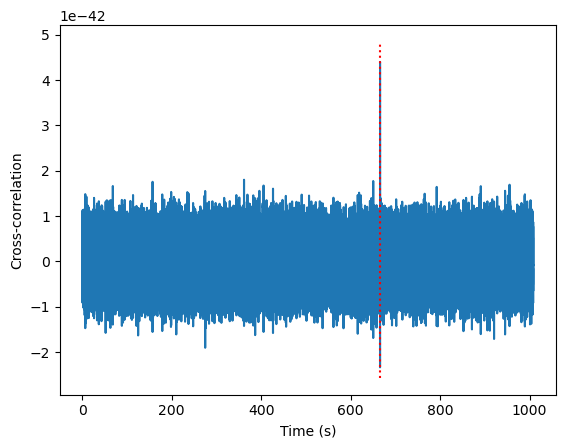

In [166]:
cross_correlation = numpy.zeros([len(data)-len(hp1)])
datanp = data2.numpy()
for i in range(len(datanp) - len(hp1np)):
    cross_correlation[i] = (hp1np * datanp[i:i+len(hp1np)]).sum()

cross_correlation_abs = numpy.abs(cross_correlation)
cross_correlation_max = max(cross_correlation_abs)
# compare to the std of the CC of the signal with noise 
# (i.e. away from the signal injection)
# can also include all noise + signal as the signal is localised so has 
# little effect on the std
cross_correlation_std  = numpy.std(cross_correlation[0:400*1024])
print("max cross-correlation, unwhitened data: ", cross_correlation_max)
print("std cross-correlation, unwhitened data: ", cross_correlation_std)
print("SNR = max/std: ", cross_correlation_max/cross_correlation_std)

# plot the cross-correlation in the time domain. Superimpose the location of the start of the signal.
# Note the size of the cross-correlation peak is, relative to the CC with the noise. This is the SNR
plt.figure()
times = numpy.arange(len(datanp) - len(hp1np)) / float(sample_rate)
plt.plot(times, cross_correlation)
plt.plot([waveform_start/float(sample_rate), waveform_start/float(sample_rate)],
           [(min(cross_correlation))*1.1,(max(cross_correlation))*1.1],'r:')
plt.xlabel('Time (s)')
plt.ylabel('Cross-correlation')
plt.show()

Now let's re-do the correlation, in the time domain, but with whitened data and template.

max cross-correlation, unwhitened data:  126440.2724687351
std cross-correlation, unwhitened data:  8121.8205740593385
SNR = max/std:  15.567971653126465


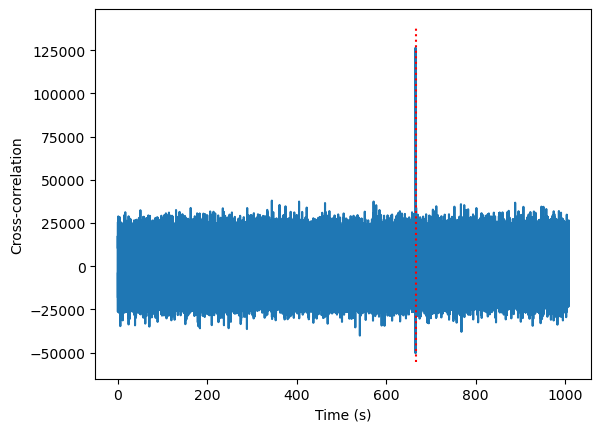

In [ ]:
cross_correlation = numpy.zeros([len(data)-len(hp1)])
hp1np = hp1_whitened.numpy()
datanp = data_whitened.numpy()
for i in range(len(datanp) - len(hp1np)):
    cross_correlation[i] = (hp1np * datanp[i:i+len(hp1np)]).sum()

cross_correlation_abs = numpy.abs(cross_correlation)
cross_correlation_max = max(cross_correlation_abs)
# compare to the std of the CC of the signal with noise 
# (i.e. away from the signal injection)
# can also include all noise + signal as the signal is localised so has 
# little effect on the std
cross_correlation_std  = numpy.std(cross_correlation[0:400*1024])
print("max cross-correlation, whitened data: ", cross_correlation_max)
print("std cross-correlation, whitened data: ", cross_correlation_std)
print("SNR = max/std: ", cross_correlation_max/cross_correlation_std)

# plot the cross-correlation in the time domain. Superimpose the location of the start of the signal.
# Note the size of the cross-correlation peak, again relative to the corr with the noise. This is the SNR.
# the SNR is bigger than for the unwhitened case.
plt.figure()
times = numpy.arange(len(datanp) - len(hp1np)) / float(sample_rate)
plt.plot(times, cross_correlation)
plt.plot([waveform_start/float(sample_rate), waveform_start/float(sample_rate)],
           [(min(cross_correlation))*1.1,(max(cross_correlation))*1.1],'r:')
plt.xlabel('Time (s)')
plt.ylabel('Cross-correlation')
plt.show()

# Challenge!

* Histogram the whitened time series. Ignoring the outliers associated with the signal, is it a Gaussian? What is the mean and standard deviation? (We have not been careful in normalizing the whitened data properly).
* Histogram the above cross-correlation time series. Ignoring the outliers associated with the signal, is it a Gaussian? What is the mean and standard deviation?
* (Optional) Find the location of the peak. (Note that here, it can be positive or negative), and the value of the SNR of the signal (which is the absolute value of the peak value, divided by the standard deviation of the cross-correlation time series).

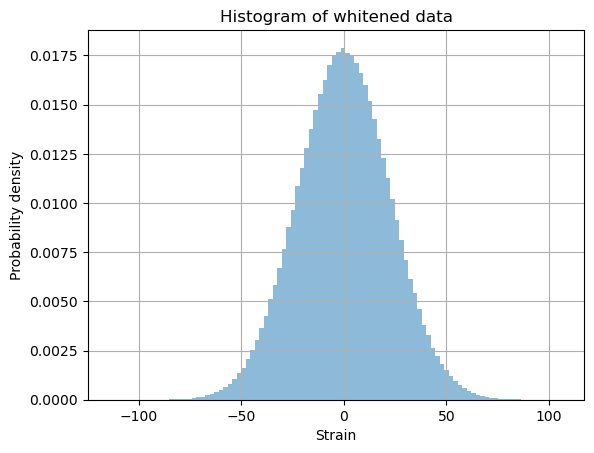

In [168]:
fig, ax = plt.subplots(1, 1, sharex=True)

ax.hist(data_whitened, bins=100, density=True, alpha=0.5, label='Whitened data')

ax.set_xlabel('Strain')
ax.set_ylabel('Probability density')
ax.set_title('Histogram of whitened data')
plt.grid()
plt.show()

The histogram of the whitened data is very close to a Gaussian distribution, as expected for whitened couloured noise a small signal

In [169]:
print("the mean is: ", numpy.mean(data_whitened))
print("the std is: ", numpy.std(data_whitened))

the mean is:  2.339030661865915e-15
the std is:  22.4138735628485


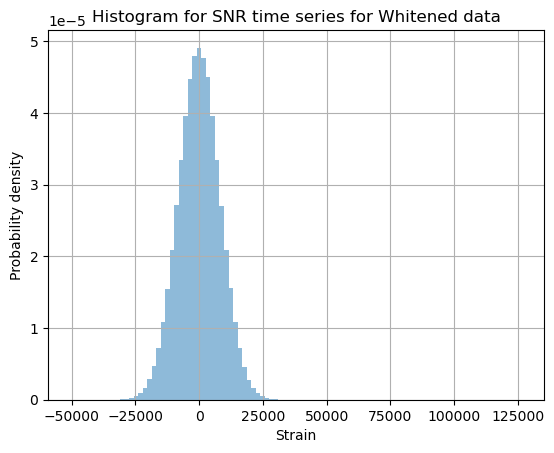

In [172]:
fig, ax = plt.subplots(1, 1, sharex=True)

ax.hist(cross_correlation, bins=100, density=True, alpha=0.5, label='SNR time series for Whitened data')

ax.set_xlabel('Strain')
ax.set_ylabel('Probability density')
ax.set_title('Histogram for SNR time series for Whitened data')
plt.grid()
plt.show()

ignoring the outliers associated with the injected signal, the cross correlation timeseries is also gaussian.

In [173]:
print("the mean is: ", numpy.mean(cross_correlation))
print("the std is: ", numpy.std(cross_correlation))

the mean is:  -0.013408485624284393
the std is:  8131.813147815785


In [174]:
print(f"location of the peak is: {numpy.argmax(numpy.abs(cross_correlation))} or at {numpy.argmax(numpy.abs(cross_correlation))/1024} seconds")

location of the peak is: 681525 or at 665.5517578125 seconds


This is where the start of the signal was injected

SNR is given by the peak SNR timexseries value divided by the standard deviation of the SNR time series

In [175]:
print("SNR is: ", cross_correlation_max/cross_correlation_std)

SNR is:  15.567971653126465
